In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
block_size = 4 
vocab_size = len(itos)
n_embd = 10 # dimensionality of the embedding space
n_hidden = 64 # dimensionality of the hidden state

In [5]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [6]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff:1.3e}')

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

bngain = torch.ones(1, n_hidden)* 0.1 + 1.0
bnbias = torch.zeros(1, n_hidden) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

4777


In [8]:
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [9]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

hprebn = embcat @ W1 + b1
bnmeani = 1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff * bndiff
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bnraw * bngain + bnbias

h = torch.tanh(hpreact)

logits = h @ W2 + b2

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb]


for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, 
          counts_sum_inv, norm_logits, logit_maxes, 
          logits, h, hpreact, bnraw, bnvar_inv, 
          bnvar, bndiff2, bndiff, hprebn, bnmeani, 
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

RuntimeError: grad can be implicitly created only for scalar outputs

In [51]:
max_steps = 200000
batch_size = 64
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact_norm = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
         bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
         bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1 if i < max_steps / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

#     lri.append(lre[i])
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item()) 
    # break

# print(loss.item())


      0 /  200000: 3.3015
  10000 /  200000: 2.2158
  20000 /  200000: 2.2176
  30000 /  200000: 2.0111
  40000 /  200000: 2.0684
  50000 /  200000: 1.9087
  60000 /  200000: 1.8553
  70000 /  200000: 2.0908
  80000 /  200000: 1.9808
  90000 /  200000: 2.2441
 100000 /  200000: 2.1040
 110000 /  200000: 1.8833
 120000 /  200000: 1.7545
 130000 /  200000: 1.7983
 140000 /  200000: 2.1366
 150000 /  200000: 1.7280
 160000 /  200000: 1.6802
 170000 /  200000: 2.0161
 180000 /  200000: 1.9462
 190000 /  200000: 1.7885


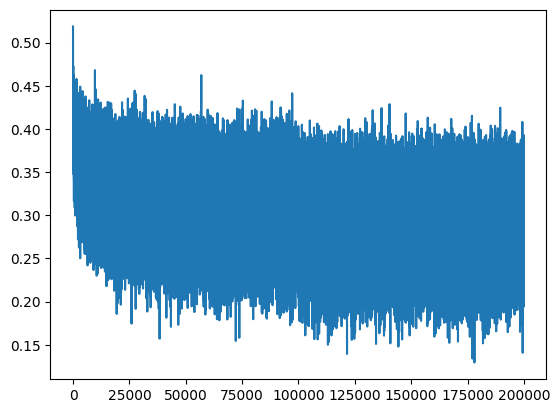

In [52]:
plt.plot(lossi)

In [53]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item()}')

split_loss('train')
split_loss('val')

train: 1.9257128238677979
val: 2.0364534854888916


In [ ]:
# train: 2.087663173675537
# val: 2.151581048965454

# train: 1.9194575548171997
# val: 2.096104860305786

# train: 1.850662350654602
# val: 2.052661657333374

# train: 1.9229381084442139
# val: 2.032777786254883

In [29]:
gener = torch.Generator().manual_seed(2147483647 + 10)
block_size = 4
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits  = h @ W2 + b2
        probs = F.softmax(logits, dim=1) 
        ix = torch.multinomial(probs, num_samples=1, generator=gener).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmahzadi.
hermi.
jarri.
taty.
salayane.
maheem.
deliah.
jareti.
nelmara.
chaiin.
kaleigh.
ham.
port.
quint.
shon.
emiliani.
waveron.
jaryn.
karmen.
dustine.
